# 基础使用指南
导入DeepQuantum以及相关库

In [1]:
import deepquantum as dq
import deepquantum.photonic as dqp
import torch
import torch.nn as nn

## 初始化
- QubitCircuit用量子比特数（n）来初始化量子线路，即cir=dq.QubitCircuit(n)。 
- QumodeCircuit用模式数（n）来初始化光量子线路，即cir=dq.QumodeCircuit(n)。

# 量子态
QubitState是表示量子态的类。 比如，我们可以利用QubitState准备一个单比特量子态，其数据是torch的tensor，存在属性state中。 便捷地将经典数据编码为一个量子态

In [4]:
qstate = dq.QubitState(nqubit=1, state=[0,1])
print(qstate.state)
qstate = dq.QubitState(nqubit=2, state='zeros')
print(qstate.state)
qstate = dq.QubitState(nqubit=2, state='equal')
print(qstate.state)
qstate = dq.QubitState(nqubit=3, state='ghz')
print(qstate.state)

tensor([[0.+0.j],
        [1.+0.j]])
tensor([[1.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j]])
tensor([[0.5000+0.j],
        [0.5000+0.j],
        [0.5000+0.j],
        [0.5000+0.j]])
tensor([[0.7071+0.j],
        [0.0000+0.j],
        [0.0000+0.j],
        [0.0000+0.j],
        [0.0000+0.j],
        [0.0000+0.j],
        [0.0000+0.j],
        [0.7071+0.j]])


# 基本的量子门
我们可以将各种量子门作用在QubitCircuit上。 例如，我们可以将Hadamard门作用于1号量子比特：cir.h(1)；将Rx门作用于2号量子比特：cir.rx(2, inputs=0.2)；多量子比特门也一样：cir.cnot(0, 1)。 同时，我们还可以一次性在量子线路上放置一层量子门，如cir.rxlayer()。 如果量子门没有指定输入参数，则会自动初始化变分参数。

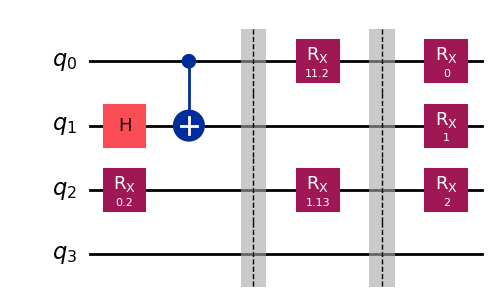

In [11]:
cir = dq.QubitCircuit(4)
cir.h(1)
cir.rx(2, inputs=0.2)
cir.cnot(0, 1)

cir.barrier()

# 我们还可以一次性在量子线路上放置一层量子门，参数随机
cir.rxlayer(wires=[0,2])

cir.barrier()

# 我们也可以手动初始化参数，具体如下所示。 利用inputs手动初始化固定参数
cir.rxlayer(wires=[0, 1, 2], inputs=[0, 1, 2])
cir.draw()

如果要求参数是可训练的，可以参考以下示例

In [12]:
# TODO
class MyCircuit(nn.Module):
    def __init__(self, nqubit):
        super().__init__()
        # 手动初始化变分参数为1
        self.params = nn.Parameter(torch.ones(nqubit))
        self.cir = self.circuit(nqubit)

    def circuit(self, nqubit):
        cir = dq.QubitCircuit(nqubit)
        cir.hlayer()
        # 利用encode，指定变分参数编码到量子线路中的位置
        cir.rylayer(encode=True)
        cir.cnot_ring()
        for i in range(nqubit):
            cir.observable(i)
        return cir

    def forward(self):
        # 在前向过程中，变分参数作为data加入量子线路
        self.cir(data=self.params)
        return self.cir.expectation().mean()

# 测量与期望
测量是量子计算的核心操作之一。 我们以对GHZ态进行测量作为例子。

{'111': 514, '000': 510}
{'11': (5004, tensor(0.5000)), '00': (4996, tensor(0.5000))}


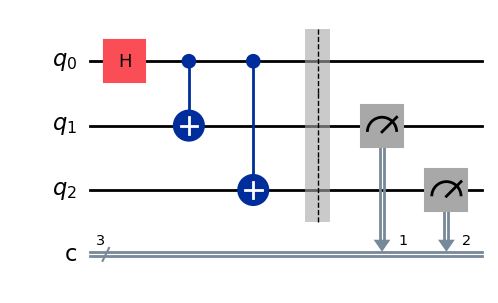

In [23]:
cir = dq.QubitCircuit(3)
cir.h(0)
cir.cnot(0, 1)
cir.cnot(0, 2)
cir.barrier()
cir() # 线路演化
# 对QubitCircuit中的末态进行测量，返回的结果是字典或者字典的列表
# 字典的key是比特串，value是对应测量到的次数
# 测量总数shots默认为1024
# 比特串从左到右对应于线路从小到大
# 即第一个qubit在最高位，最后一个qubit在最低位
print(cir.measure())
# 我们也可以设定采样次数、进行部分测量以及显示理想的概率。
print(cir.measure(shots=10000, wires=[1,2], with_prob=True))
cir.draw()

使用参数化量子线路进行变分量子算法时，往往涉及对末态求某个力学量的期望值，下面我们就用最简单的量子线路演示一下。
(注意，defer_measure和post_select并不改变QubitCircuit所保存的末态state，因此measure和expectation目前并不兼容条件测量。)

tensor([-1.,  1., -1.,  1.])


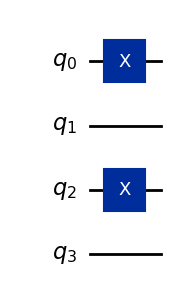

In [25]:
cir = dq.QubitCircuit(4)
cir.xlayer([0,2])
# 可以添加多个observable，各个期望值的结果会自动拼接起来
# 还可以使用列表形式的组合来灵活地指定测量线路和测量基底
# 如wires=[0,1,2]、basis='xyz'
# 即表示0、1、2号线路上分别对应Pauli-X、Pauli-Y、Pauli-Z的力学量
for i in range(4):
    cir.observable(i)
cir() # 线路演化后才能得到期望值
print(cir.expectation())
cir.draw()

# QumodeCircuit基础使用说明
使用Fock后端可以构建基于**离散变量的光量子线路**，basis=True对应着量子态用Fock基矢态表示，basis=False对应着量子态用Fock态张量表示。

## 量子态
Fock基矢态表示只支持单一的量子态输入，Fock态张量表示支持叠加态输入。

In [27]:
qstate1 = dq.FockState(state=[1,0,1,0], basis=True)
qstate2 = dq.FockState(state=[(0.6, [1,0,1,0]), (0.8, [1,1,0,0])], 
                       basis=False)
print(qstate1)
print(qstate2)

|1010>
state_0: (0.800+0.000j)|1100> + (0.600+0.000j)|1010>



## 基本量子门
我们可以将各种量子门作用在QumodeCircuit上。 例如，我们可以将移相器作用于第1个mode：cir.ps(0)；将分束器作用于第1、2个mode：cir.bs([0,1])。 如果量子门没有指定输入参数，则会自动初始化变分参数。

In [30]:
init_state = [1,0]
cir = dq.QumodeCircuit(nmode=2, init_state=init_state, cutoff=3, backend='fock', basis=True)
cir.ps(0, torch.pi)
cir.ps(1, torch.pi)
cir.bs([0,1], [torch.pi/4, torch.pi/4])
cir.mzi([0,1], [torch.pi/4, torch.pi/4])
cir.draw()

## 线路演化和测量

In [31]:
state = cir()
sample = cir.measure()
print(state, sample)

{|10>: tensor([0.8536-0.3536j]), |01>: tensor([0.3536-0.1464j])} {|10>: 872, |01>: 152}


# 线路可视化

In [32]:
cir.draw(filename='circuit.svg')

# Clements 的使用
构建基于Clements架构的光量子线路，可以通过Clements架构实现任意的光量子酉矩阵线路映射，下面是一个简单CNOT门的例子。 这里使用6模线路来实现一个1/9成功率的CNOT门，第1、2个mode对应控制比特，第3、4个mode对应目标比特，第5、6个mode为辅助mode。

In [33]:
u6x6 = torch.tensor([[1, 0, 1, -1, 0, 0],
                     [0, 1, 0, 0, 0, 2 ** 0.5],
                     [1, 0, 0, 1, 1, 0],
                     [-1, 0, 1, 0, 1, 0],
                     [0, 0, 1, 1, -1, 0],
                     [0, 2 ** 0.5, 0, 0, 0, -1]]) / 3 ** 0.5
# 将酉矩阵分解成clements对应的参数
ud = dq.UnitaryDecomposer(u6x6)
angle_dict = ud.decomp()[2]
clements = dq.Clements(nmode=6, init_state=[1,0,1,0,0,0], cutoff=3)
data = clements.dict2data(angle_dict) # 将线路参数编码到6x6的Clements架构中
state = clements(data=data)
clements.draw()

通过后选择挑选出对应的量子态，后选择规则是第1、2个mode探测到光子数之和为1，同时第3、4个mode探测到光子数之和也为1，挑选出的结果为|101000>，对应的概率为1/9。

# Gaussian后端的使用
使用Gaussian后端可以构建基于连续变量的光量子线路，量子态通过正交算符和的协方差矩阵和平均值矢量来表示。

## 量子态
高斯态通过协方差矩阵cov和平均值矢量mean来表示，’vac’对应真空态，也可以设置cov和mean。

In [35]:
qstate1 = dq.GaussianState(nmode=2, state='vac')
cov = torch.eye(4)
mean = torch.zeros(4)
qstate2 = dq.GaussianState(nmode=2, state=[cov, mean])
print(qstate1, qstate2)

GaussianState() GaussianState()


## 基本量子门
高斯操作对应的量子门有单模压缩门s、位移门d、旋转门r和分束器bs等。

In [36]:
cir = dq.QumodeCircuit(nmode=2, init_state='vac', cutoff=3, backend='gaussian')
cir.s(0, [0.1,0])
cir.s(1, [0.2,0])
cir.d(0, [0.3,0])
cir.d(1, [0.4,0])
cir.bs([0,1], [torch.pi/4, torch.pi/4])
#线路可视化
cir.draw()

## 线路演化和测量
这里measure_homodyne测量对应的物理量是正交算符 $\hat x$ 和 $\hat p$ 的值，photon_number_mean_var对应的是每个mode的光子数的平均值和方差。

In [39]:
state = cir()
sample = cir.measure_homodyne()
photon_number = cir.photon_number_mean_var()
print(sample)
print(photon_number)

tensor([[ 1.3076, -0.6707,  1.2913,  0.4728],
        [-0.2566,  0.5584, -1.9569,  0.9789],
        [-0.1465,  1.6749, -0.4834, -1.1516],
        ...,
        [-0.1452,  1.2278,  1.3136, -0.1687],
        [-0.3568,  2.4952, -2.1163, -0.4610],
        [-0.7633,  2.1527,  0.0634, -1.6993]])
(tensor([0.0654, 0.2351]), tensor([0.0862, 0.2125]))


# 高斯玻色采样（GBS）
通过压缩门和线性光学器件构造高斯玻色采样的线路。 这里采用6个节点的图演示简单的高斯玻色采样。

In [40]:
adj_mat = torch.tensor([[0., 1., 1., 0., 0., 0.],
                        [1., 0., 0., 1., 0., 1.],
                        [1., 0., 0., 0., 0., 0.],
                        [0., 1., 0., 0., 1., 1.],
                        [0., 0., 0., 1., 0., 0.],
                        [0., 1., 0., 1., 0., 0.]])
gbs = dqp.GBS_Graph(adj_mat=adj_mat, cutoff=2)
state = gbs()
sample = gbs.measure() # 高斯玻色采样
print(sample)

chain 5: 100%|█████████████████████████████| 207/207 [00:00<00:00, 18068.74it/s]

{|111111>: 2, |000101>: 123, |110000>: 48, |101000>: 85, |000000>: 456, |010100>: 62, |111001>: 10, |010001>: 88, |110101>: 15, |101110>: 21, |000110>: 38, |111100>: 18, |101101>: 19, |110110>: 17, |010111>: 18, |011000>: 2, |011011>: 2}


通过gbs.draw()可以可视化高斯玻色采样线路。

In [41]:
gbs.draw()